In [1]:
import time
import numpy
import scipy
from matplotlib import pyplot
from matplotlib import patches
import autograd
from autograd import numpy as ag_numpy
import tqdm
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
pyplot.rcParams['figure.dpi'] = 150
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
def next_fig() -> int:
    """
    Get appropriate handle for next figure
    """
    fignums = pyplot.get_fignums()
    if fignums:
        fignums = sorted(fignums)
        n_figs = len(fignums)
        if fignums[-1] == n_figs:
            next_num = n_figs + 1
        else:
            next_num = -1
            for n, fignum in enumerate(fignums, start=1):
                if fignum > n:
                    next_num = n
                    break
            if next_num <= 0:
                raise RuntimeError("Unable to find next figure number")
    else:
        next_num = 1
    return next_num

In [4]:
def normal_samples(shape, mean=0.0, scale=1.0):
    """
    Samples from normal distribution
    """
    return numpy.random.normal(loc=mean, scale=scale, size=shape)

def relu(x):
    return ag_numpy.maximum(x, 0.0)

def rbf(x):
    return ag_numpy.exp(-x ** 2)

def make_nn_params_as_list_of_dicts(
        n_hiddens_per_layer,
        n_dims_input=1,
        n_dims_output=1,
        weight_fill_func=numpy.zeros,
        bias_fill_func=numpy.zeros):
    if not isinstance(n_hiddens_per_layer, tuple):
        n_hiddens_per_layer = tuple(n_hiddens_per_layer)
    n_hiddens_per_layer = (n_dims_input,) + n_hiddens_per_layer + (n_dims_output,)

    # Given full network size list is (a, b, c, d, e)
    # For loop should loop over (a,b) , (b,c) , (c,d) , (d,e)
    nn_param_list = tuple(
        {"w": weight_fill_func((n_in, n_out)), "b": bias_fill_func((n_out,))}
        for n_in, n_out in zip(n_hiddens_per_layer[:-1], n_hiddens_per_layer[1:])
    )
    return nn_param_list

def predict_y_given_x_with_NN(x, nn_param_list, activation_func=ag_numpy.tanh):
    """ Predict y value given x value via feed-forward neural net
    
    Args
    ----
    x : array_like, n_examples x n_input_dims
    
    Returns
    -------
    y : array_like, n_examples
    """
    input_size = nn_param_list[0]["w"].shape[0]
    
    # compute linear excitation of first layer
    layer_iter = ((layer['w'], layer['b']) for layer in nn_param_list)
    weights, bias = next(layer_iter)
    y = x.reshape(-1, input_size) @ weights + bias

    for weights, bias in layer_iter:
        # for any remaining layers, compute linear exciation from  output of activation function for previous layer
        y = activation_func(y) @ weights + bias

    return y.squeeze()

# Problem 1

<IPython.core.display.Javascript object>


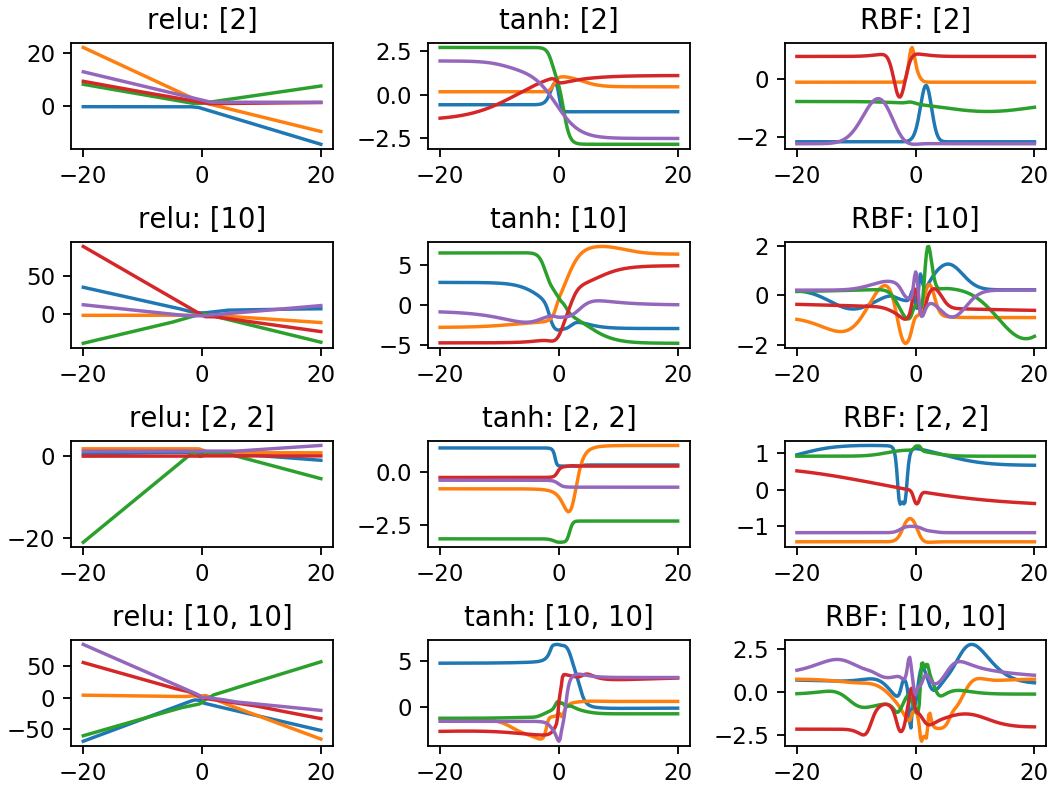

In [5]:
num_x_grid = 201
num_samples = 5
x_grid = numpy.linspace(-20.0, 20.0, num_x_grid)
architectures = ((2,), (10,), (2,2), (10, 10))
activations = (relu, ag_numpy.tanh, rbf)
activation_names = ("relu", "tanh", "RBF")

fig = pyplot.figure(num=next_fig(), constrained_layout=True)
gridspec = fig.add_gridspec(len(architectures), len(activations))
last_row = len(architectures) - 1
for row, architecture in enumerate(architectures):
    for col, (activation, activation_name) in enumerate(zip(activations, activation_names)):
        ax = fig.add_subplot(gridspec[row, col])

        for __ in range(num_samples):
            nn_param_list = make_nn_params_as_list_of_dicts(
                architecture,
                n_dims_input=1,
                n_dims_output=1,
                weight_fill_func=normal_samples,
                bias_fill_func=normal_samples
            )
            y = predict_y_given_x_with_NN(x_grid, nn_param_list, activation_func=activation)

            ax.plot(x_grid, y, '-')
            ax.set_title("%s: %s" % (activation_name, str(list(architecture))))           


# Problem 2

In [6]:
def sqrt_pos_semidef(m):
    try:
        r = numpy.linalg.cholesky(m)
    except numpy.linalg.LinAlgError:
        u, s, v = numpy.linalg.svd(m, hermitian=True)
        r = u @ numpy.diag(numpy.sqrt(s))
    return r

def draw_GP_samples(
        mean_vec,
        cov_mat,
        random_state=0,
        n_samples=1
):
    """
    Draw sample from GP prior given mean/cov functions

    Args
    ----
    mean_vec : 1D array, size n_grid_pts
        mean value of GP at each input x_i value 
    cov_mat : 2D matrix, n_grid_pts x n_grid_pts
        Covariance (kernel) matrix at each pair of inputs.
    random_state : int or numpy.random.RandomState
        Seed for the random number generator
    n_samples : int (default=1)
        Number of samples to draw from the prior

    Returns
    -------
    y_samples : 2D array, n_samples x n_grid_pts
        Contains sampled function values at each point of x_grid
    """
    if not isinstance(random_state, numpy.random.RandomState):
        random_state = numpy.random.RandomState(random_state)
    sqrt_k = sqrt_pos_semidef(cov_mat)
    
    return mean_vec.reshape(1, -1) + numpy.random.randn(n_samples, mean_vec.size) @ sqrt_k.transpose()

def default_kinetic_energy(momentum, inv_mass_matrix = None):
    return 0.5 * ag_numpy.sum(momentum ** 2) if inv_mass_matrix is None \
        else momentum.reshape(1, -1) @ inv_mass_matrix @ momentum.reshape(-1, 1)

def layer_params_to_flat_params(layer_params):
    def _gen_params():
        for layer in layer_params:
            yield layer['w'].flatten()
            yield layer['b'].flatten()
    
    flat_params = ag_numpy.concatenate(_gen_params())
    layer_shapes = tuple((layer['w'].shape, layer['b'].shape) for layer in layer_params)
    return flat_params, layer_shapes

def flat_params_to_layer_params(flat_params, layer_shapes):
    def _gen_params():
        start_ind = 0
        for w_shape, b_shape in layer_shapes:
            mid_ind = start_ind + numpy.prod(w_shape)
            end_ind = mid_ind + numpy.prod(b_shape)
            yield flat_params[start_ind:mid_ind].reshape(w_shape), flat_params[mid_ind:end_ind].reshape(b_shape)
            start_ind = end_ind
    
    layer_params = tuple({'w': w, 'b': b} for w, b in _gen_params())
    return layer_params

def flat_params_to_y_predict(flat_params, layer_shapes, x, activation_func):
    layer_params = flat_params_to_layer_params(flat_params, layer_shapes)
    y_predict = predict_y_given_x_with_NN(x, layer_params, activation_func=activation)
    return y_predict

def nn_energy(flat_params, layer_shapes, x, y, activation_func, sigma_data, sigma_weights):
    y_predict = flat_params_to_y_predict(flat_params, layer_shapes, x, activation_func)
    return 0.5 * (
        ag_numpy.sum(
            ((y_predict - y) / sigma_data) ** 2
        )
        + ag_numpy.sum(
            (flat_params / sigma_weights) ** 2
        )
    )

def run_HMC_sampler(
        initial_params,
        calc_potential_energy,
        calc_potential_energy_kwargs = None,
        calc_kinetic_energy = default_kinetic_energy,
        calc_kinetic_energy_kwargs = None,
        calc_grad_potential_energy = None,
        n_hmc_iters=100,
        n_leapfrog_steps=1,
        step_size=1.0,
        random_state=None,
        num_progress_updates=10
):
    """ Run HMC sampler for many iterations (many proposals)

    Returns
    -------
    bnn_samples : list
        List of samples of NN parameters produced by HMC
        Can be viewed as 'approximate' posterior samples if chain runs to convergence.
    info : dict
        Tracks energy values at each iteration and other diagnostics.

    References
    ----------
    See Neal's pseudocode algorithm for a single HMC proposal + acceptance:
    https://arxiv.org/pdf/1206.1901.pdf#page=14

    This function repeats many HMC proposal steps.
    """
    # Create random-number-generator with specific seed for reproducibility
    if not isinstance(random_state, numpy.random.RandomState):
        random_state = numpy.random.RandomState(random_state)

    if calc_potential_energy_kwargs is None:
        calc_potential_energy_kwargs = {}
    if calc_kinetic_energy_kwargs is None:
        calc_kinetic_energy_kwargs = {}
    if calc_grad_potential_energy is None:
        calc_grad_potential_energy = autograd.grad(calc_potential_energy)
    
    # Set initial bnn params
    params = initial_params
    momentum = random_state.randn(*params.shape)
    potential_energy = calc_potential_energy(params, **calc_potential_energy_kwargs)

    param_samples = numpy.empty((n_hmc_iters, params.size))
    potential_energy_samples = numpy.empty((n_hmc_iters,))

    n_accept = 0
    start_time_sec = time.time()
    update_interval = None if num_progress_updates == 0 else (n_hmc_iters // num_progress_updates)
    for t in range(n_hmc_iters):
        # Draw momentum for CURRENT configuration
        momentum = random_state.randn(*params.shape)
        kinetic_energy = calc_kinetic_energy(momentum, **calc_kinetic_energy_kwargs)

        # Create PROPOSED configuration
        proposed_params, proposed_momentum = make_proposal_via_leapfrog_steps(
            params, momentum,
            n_leapfrog_steps=n_leapfrog_steps,
            step_size=step_size,
            calc_grad_potential_energy=calc_grad_potential_energy,
            calc_potential_energy_kwargs=calc_potential_energy_kwargs
        )
        
        proposed_potential_energy = calc_potential_energy(proposed_params, **calc_potential_energy_kwargs)
        proposed_kinetic_energy = calc_kinetic_energy(proposed_momentum, **calc_kinetic_energy_kwargs)

        # decide whether to accept or reject proposed params and momentum
        minus_delta_e = potential_energy - proposed_potential_energy + kinetic_energy - proposed_kinetic_energy
        # If minus_delta_e is positive accept,
        # otherwise p_accept = exp(-delta_e), so draw random value from (0,1) to determine if we accept or not
        if minus_delta_e > 0 or random_state.rand() < numpy.exp(minus_delta_e):
            # If here, we accepted the proposal
            n_accept += 1 
            params = proposed_params
            potential_energy = proposed_potential_energy

        # Update list of samples from "posterior"
        param_samples[t, :] = params
        potential_energy_samples[t] = potential_energy

        # Print some diagnostics every update_interval iters
        if update_interval is not None and ((t % update_interval == 0) or (t+1) == n_hmc_iters):
            accept_rate = float(n_accept) / float(t+1)
            print(
                "iter %6d/%d after %7.1f sec | accept_rate %.3f"
                % (t+1, n_hmc_iters, time.time() - start_time_sec, accept_rate)
            )

    accept_rate = n_accept / n_hmc_iters
    return param_samples, potential_energy_samples, accept_rate

def make_proposal_via_leapfrog_steps(
        params, momentum,
        calc_grad_potential_energy,
        calc_potential_energy_kwargs,
        n_leapfrog_steps=1,
        step_size=1.0
):
    """ Construct one HMC proposal via leapfrog integration

    Returns
    -------
    prop_bnn_params : same type/size as cur_bnn_params
    prop_momentum_vec : same type/size as cur_momentum_vec

    """
    # take first half step for momentum, and first whole step for position
    proposed_momentum = momentum \
                      - (0.5 * step_size) * calc_grad_potential_energy(params, **calc_potential_energy_kwargs)
    proposed_params = params + step_size * proposed_momentum

    n_leapfrog_steps -= 1
    while n_leapfrog_steps:
        # take intermediate full step in momentum
        proposed_momentum = proposed_momentum \
                          - step_size * calc_grad_potential_energy(proposed_params, **calc_potential_energy_kwargs)
        # take full step in position
        proposed_params = proposed_params \
                          + step_size * proposed_momentum
        n_leapfrog_steps -= 1
    
    # take final half_step in momentum
    proposed_momentum = momentum \
                      - (0.5 * step_size) * calc_grad_potential_energy(params, **calc_potential_energy_kwargs)

    # TODO: don't forget to flip sign of momentum (ensure symmetry)
    # Sorry, no: I think this is cargo-cult numerics
    
    return proposed_params, proposed_momentum

def run_HMC_chain(
        param_initializer,
        calc_potential_energy,
        calc_potential_energy_kwargs = None,
        calc_kinetic_energy = default_kinetic_energy,
        calc_kinetic_energy_kwargs = None,
        calc_grad_potential_energy = None,
        n_check_burnin_iters=1.0,
        n_hmc_iters=1000,
        n_burnin_leapfrog_steps=1,
        n_sample_leapfrog_steps=10,
        max_burnin_delta_z=0.0,
        step_size=0.01,
        random_state=None,
        num_chains=1,
        num_progress_updates=0
):
    """
    """
    if not isinstance(random_state, numpy.random.RandomState):
        random_state = numpy.random.RandomState(random_state)
    
    # form initial params
    initial_params = param_initializer()
    
    n_burnin_iters = 0 if n_check_burnin_iters is None else max(int(n_check_burnin_iters / step_size), 6)
    need_burnin = n_burnin_iters > 0
    n_total_burnin_iters = 0
    while need_burnin:
        # burn in chain
        burnin_param_samples, burnin_potential_energy_samples, __ = run_HMC_sampler(
            initial_params,
            calc_potential_energy = calc_potential_energy,
            calc_potential_energy_kwargs = calc_potential_energy_kwargs,
            calc_kinetic_energy = calc_kinetic_energy,
            calc_kinetic_energy_kwargs = calc_kinetic_energy_kwargs,
            calc_grad_potential_energy = calc_grad_potential_energy,
            n_hmc_iters=n_burnin_iters,
            n_leapfrog_steps=n_burnin_leapfrog_steps,
            step_size=step_size,
            random_state=random_state,
            num_progress_updates=num_progress_updates
        )
        n_total_burnin_iters += n_burnin_iters
        initial_params = burnin_param_samples[-1]
        
        first_half_pe = burnin_potential_energy_samples[:n_burnin_iters // 2]
        second_half_pe = burnin_potential_energy_samples[n_burnin_iters // 2:]
        delta_z = (numpy.median(first_half_pe) - numpy.median(second_half_pe)) \
                / numpy.sqrt(numpy.var(first_half_pe) + numpy.var(second_half_pe))
        need_burnin = delta_z > max_burnin_delta_z
    if n_burnin_iters > 0:
        print("Burned in after %.1f full steps" % (n_total_burnin_iters * step_size))
    else:
        print("Skipping burn-in")
        
    # now just sample
    param_samples, potential_energy_samples, accept_rate = run_HMC_sampler(
            initial_params,
            calc_potential_energy = calc_potential_energy,
            calc_potential_energy_kwargs = calc_potential_energy_kwargs,
            calc_kinetic_energy = calc_kinetic_energy,
            calc_kinetic_energy_kwargs = calc_kinetic_energy_kwargs,
            n_hmc_iters=n_hmc_iters,
            n_leapfrog_steps=n_sample_leapfrog_steps,
            step_size=step_size,
            random_state=random_state,
            num_progress_updates=num_progress_updates
        )
    
    if num_chains > 1:
        param_samples = [param_samples]
        potential_energy_samples = [potential_energy_samples]
        accept_rate = [accept_rate]
        for __ in range(1, num_chains):
            _params, _energies, _r = run_HMC_chain(
                param_initializer,
                calc_potential_energy,
                calc_potential_energy_kwargs = calc_potential_energy_kwargs,
                calc_kinetic_energy = calc_kinetic_energy,
                calc_kinetic_energy_kwargs = calc_kinetic_energy_kwargs,
                calc_grad_potential_energy = calc_grad_potential_energy,
                n_check_burnin_iters=n_check_burnin_iters,
                n_hmc_iters=n_hmc_iters,
                n_burnin_leapfrog_steps=n_burnin_leapfrog_steps,
                n_sample_leapfrog_steps=n_sample_leapfrog_steps,
                max_burnin_delta_z=max_burnin_delta_z,
                step_size=step_size,
                random_state=random_state,
                num_chains=1
            )
            param_samples.append(_params)
            potential_energy_samples.append(_energies)
            accept_rate.append(_r)
        param_samples = numpy.stack(param_samples)
        potential_energy_samples = numpy.stack(potential_energy_samples)
        accept_rate = numpy.stack(accept_rate)
    return param_samples, potential_energy_samples, accept_rate
    

iter      1/500 after     0.0 sec | accept_rate 1.000
iter     51/500 after     0.4 sec | accept_rate 0.804
iter    101/500 after     0.8 sec | accept_rate 0.743
iter    151/500 after     1.2 sec | accept_rate 0.788
iter    201/500 after     1.5 sec | accept_rate 0.766
iter    251/500 after     1.9 sec | accept_rate 0.761
iter    301/500 after     2.3 sec | accept_rate 0.761
iter    351/500 after     2.7 sec | accept_rate 0.755
iter    401/500 after     3.1 sec | accept_rate 0.761
iter    451/500 after     3.5 sec | accept_rate 0.758
iter    500/500 after     3.8 sec | accept_rate 0.764


<IPython.core.display.Javascript object>


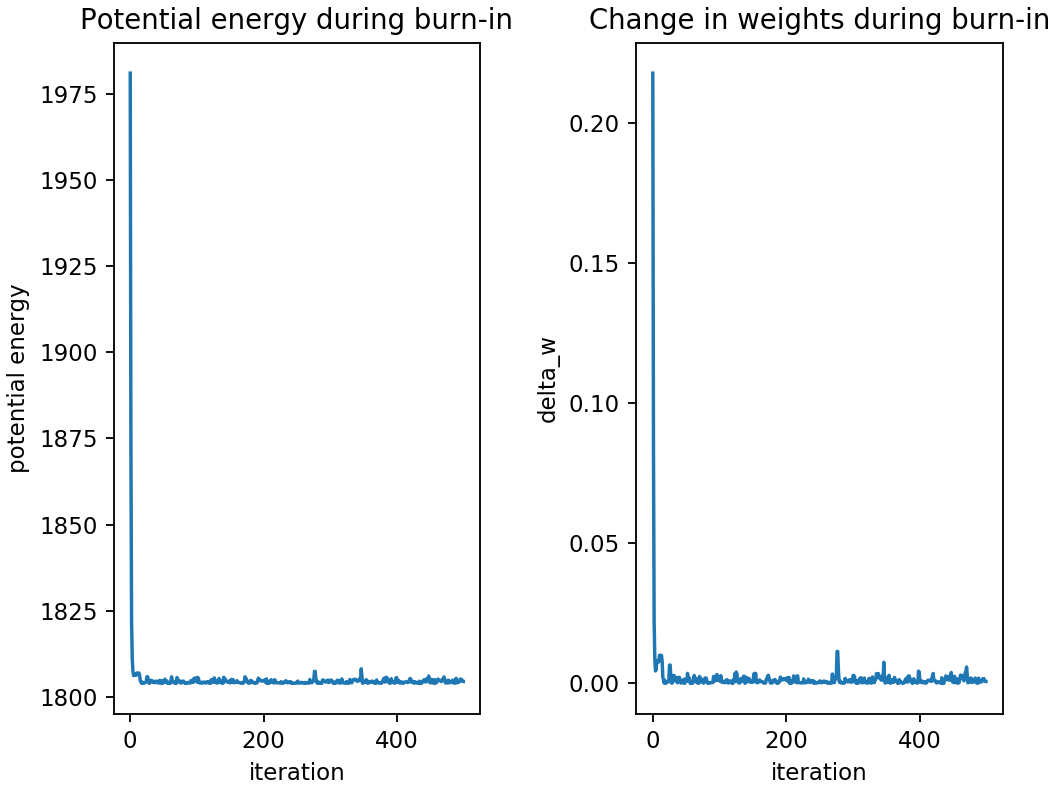

<IPython.core.display.Javascript object>


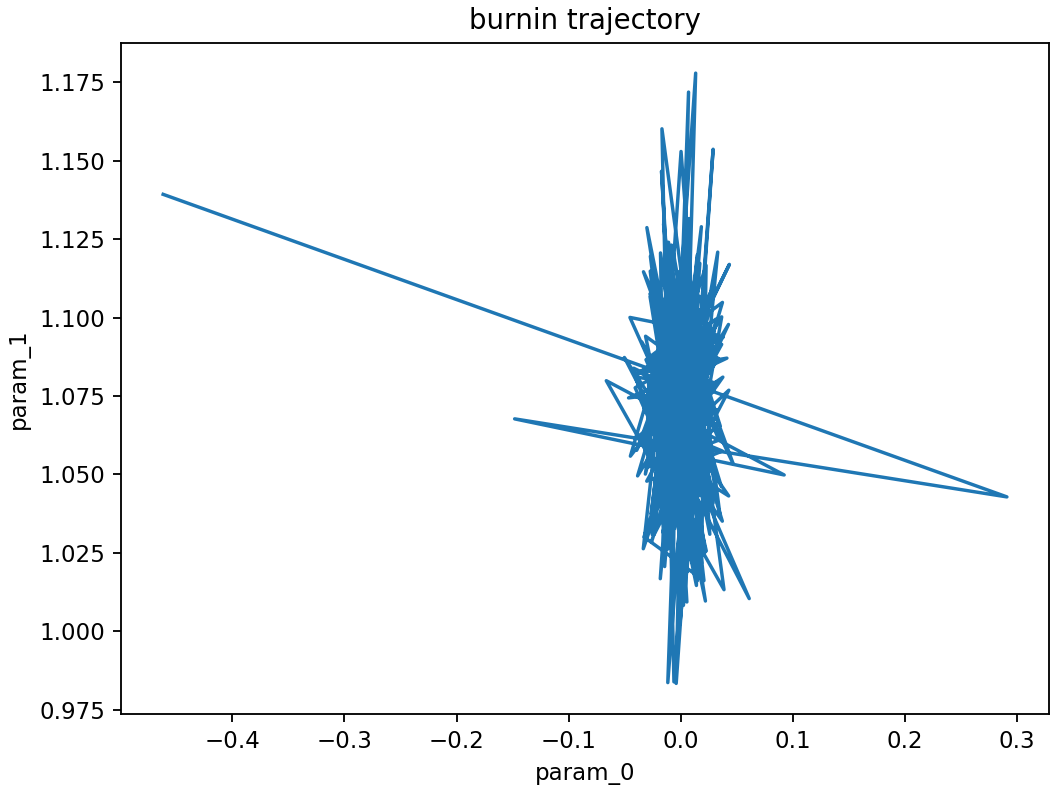

Text(0, 0.5, 'param_1')

In [7]:
x_train = numpy.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
y_train = numpy.asarray([-2.,  1.2224,    4.,  4.,  1.2224, -2.])
weights_sigma = 1.0
data_sigma = 0.1
architecture = tuple()

_fill_normal = lambda *args: normal_samples(*args, scale=weights_sigma)
layer_params = make_nn_params_as_list_of_dicts(
        architecture, n_dims_input=1, n_dims_output=1, weight_fill_func=_fill_normal, bias_fill_func=_fill_normal
)
initial_params, layer_shapes = layer_params_to_flat_params(layer_params)
nn_kwargs = {
    "layer_shapes": layer_shapes,
    "x": x_train,
    "y": y_train,
    "activation_func": None,
    "sigma_data": data_sigma,
    "sigma_weights": weights_sigma
}

step_size = 0.01
n_full_burnin_steps = 5.0
n_burnin_iters = int(n_full_burnin_steps / step_size)
n_burnin_leapfrog_steps = 10
n_hmc_iters = int(n_burnin_iters / step_size)

param_samples, potential_energy_samples, accept_rate = run_HMC_sampler(
        initial_params,
        calc_potential_energy = nn_energy,
        calc_potential_energy_kwargs = nn_kwargs,
        calc_kinetic_energy = default_kinetic_energy,
        calc_kinetic_energy_kwargs = None,
        n_hmc_iters=n_burnin_iters,
        n_leapfrog_steps=n_burnin_leapfrog_steps,
        step_size=step_size,
        random_state=None,
)

fig = pyplot.figure(num=next_fig(), constrained_layout=True)
gridspec = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gridspec[0, 0])
ax.plot(potential_energy_samples)
ax.set_ylabel("potential energy")
ax.set_xlabel("iteration")
ax.set_title("Potential energy during burn-in")

w_median = numpy.median(param_samples, axis=0)
delta_w = numpy.sum((numpy.array(param_samples) - w_median) ** 2, axis=1)
ax = fig.add_subplot(gridspec[0, 1])
ax.plot(delta_w)
ax.set_ylabel("delta_w")
ax.set_xlabel("iteration")
ax.set_title("Change in weights during burn-in");

# note a "good" trajectory should look crazy, not like an orbit.
# if the trajectory looks smooth, then subsequent samples are not independent
fig = pyplot.figure(num=next_fig(), constrained_layout=True)
gridspec = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gridspec[0, 0])
ax.plot(param_samples[:, 0], param_samples[:, 1])
ax.set_title("burnin trajectory")
ax.set_xlabel("param_0")
ax.set_ylabel("param_1")

posterior_mean: [0.         1.07234609]
posterior_covar: [[0.00060643 0.        ]
 [0.         0.00166389]]
Burned in after 4.0 full steps
Burned in after 2.0 full steps
Burned in after 1.0 full steps


<IPython.core.display.Javascript object>


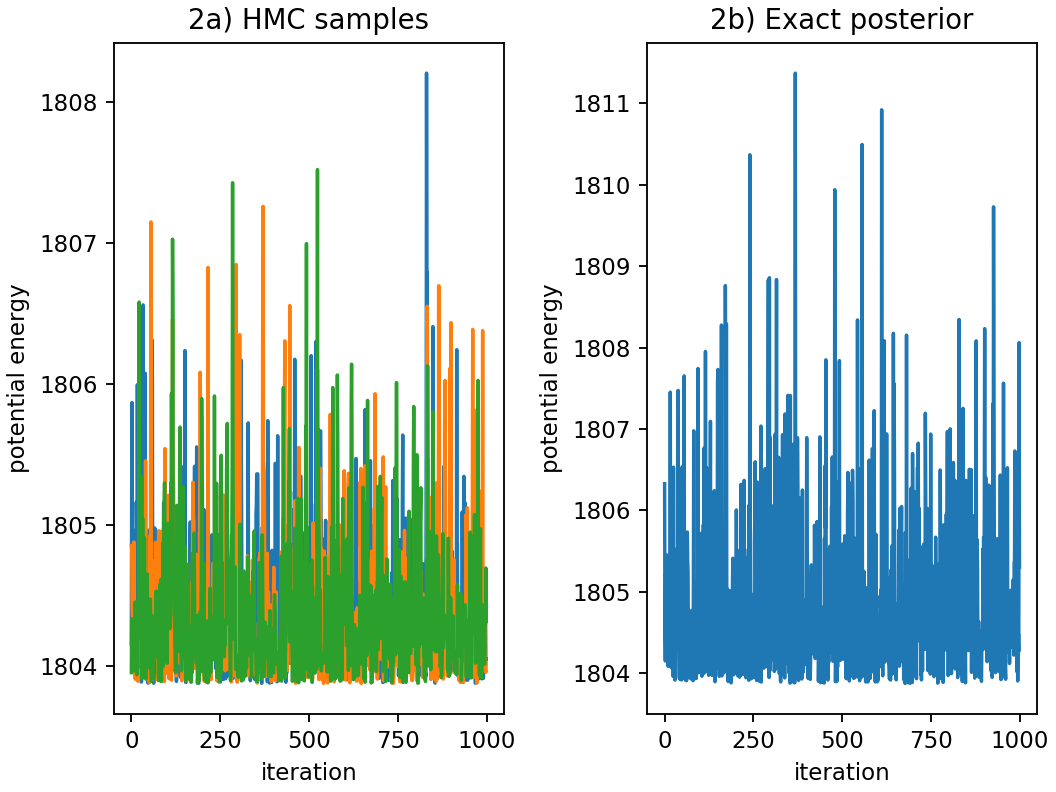

<IPython.core.display.Javascript object>


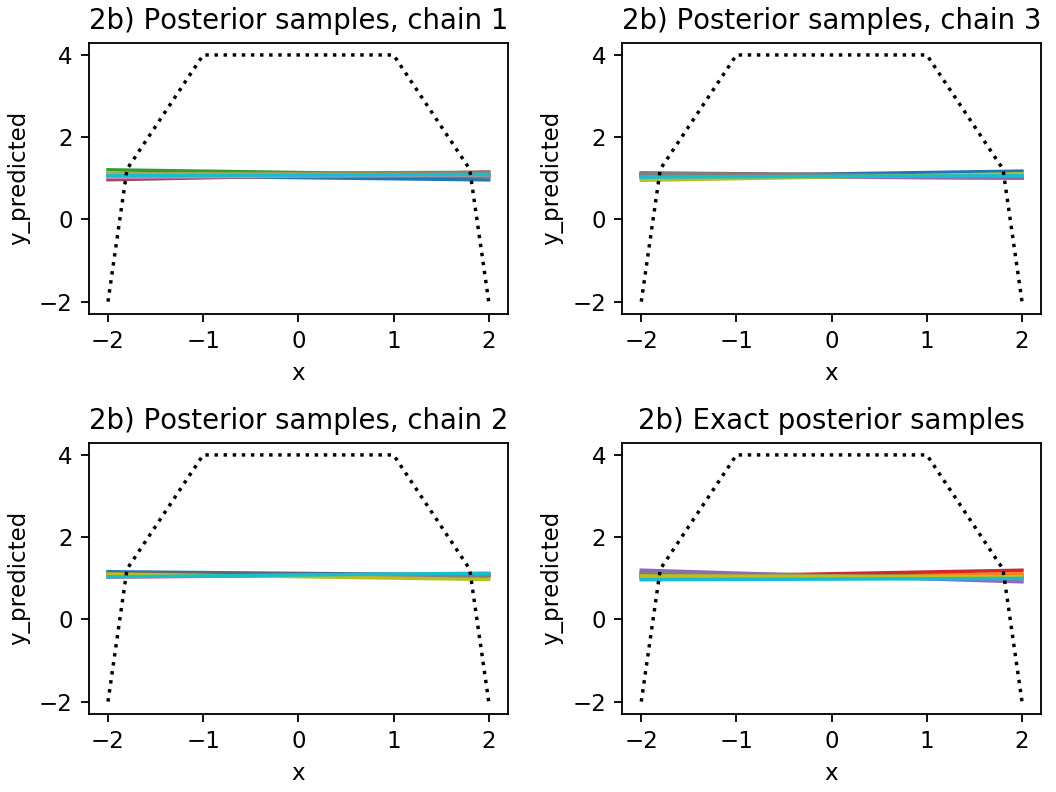

<IPython.core.display.Javascript object>


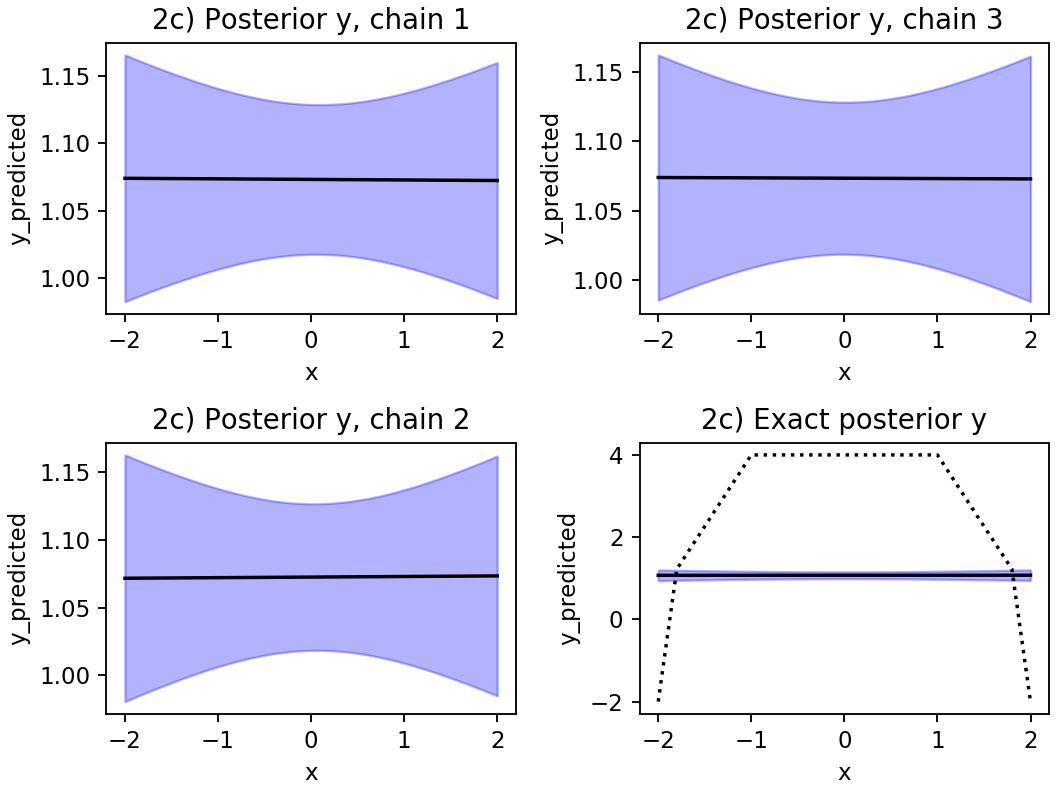

In [8]:
x_train = numpy.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
y_train = numpy.asarray([-2.,  1.2224,    4.,  4.,  1.2224, -2.])
weights_sigma = 1.0
data_sigma = 0.1
architecture = tuple()
n_hmc_iters = 1000
num_chains = 3
step_size=0.01

_fill_normal = lambda *args: normal_samples(*args, scale=weights_sigma)
layer_params = make_nn_params_as_list_of_dicts(
        architecture, n_dims_input=1, n_dims_output=1, weight_fill_func=_fill_normal, bias_fill_func=_fill_normal
)
initial_params, layer_shapes = layer_params_to_flat_params(layer_params)
nn_kwargs = {
    "layer_shapes": layer_shapes,
    "x": x_train,
    "y": y_train,
    "activation_func": None,
    "sigma_data": data_sigma,
    "sigma_weights": weights_sigma
}
def _param_initializer():
    _layer_params = make_nn_params_as_list_of_dicts(
        architecture, n_dims_input=1, n_dims_output=1, weight_fill_func=_fill_normal, bias_fill_func=_fill_normal
    )
    _initial_params, __ = layer_params_to_flat_params(_layer_params)
    return _initial_params

weights_mean, __ = layer_params_to_flat_params(
    make_nn_params_as_list_of_dicts(
        architecture, n_dims_input=1, n_dims_output=1, weight_fill_func=numpy.zeros, bias_fill_func=numpy.zeros
    )
)

# compute exact posterior
def _pinv(_mat, hermitian=True):
    return numpy.linalg.pinv(_mat, hermitian=hermitian)

weights_covar = (weights_sigma ** 2) * numpy.eye(weights_mean.size)
design_mat = numpy.stack((x_train, numpy.ones(x_train.shape)), axis=1)
data_covar = (data_sigma ** 2)
weights_posterior_covar = _pinv(_pinv(weights_covar) + (1.0 / data_covar) * (design_mat.transpose() @ design_mat))
weights_posterior_mean = weights_posterior_covar @ (_pinv(weights_covar) @ weights_mean
                                                    + (1.0 / data_covar) * design_mat.transpose() @ y_train)
print("posterior_mean: %s" % str(weights_posterior_mean))
print("posterior_covar: %s" % str(weights_posterior_covar))
exact_posterior_weights_samples = draw_GP_samples(
        weights_posterior_mean,
        weights_posterior_covar,
        n_samples=n_hmc_iters
)
exact_posterior_pe_samples = numpy.array(
    [
        nn_energy(
            exact_posterior_weights_samples[_n].flatten(), layer_shapes, x_train, y_train,
            activation_func=None, sigma_data=data_sigma, sigma_weights=weights_sigma
        ) for _n in range(n_hmc_iters)
    ]
)

# Run HMC chain
param_samples, potential_energy_samples, accept_rate = run_HMC_chain(
        _param_initializer,
        calc_potential_energy = nn_energy,
        calc_potential_energy_kwargs = nn_kwargs,
        calc_kinetic_energy = default_kinetic_energy,
        num_chains=3,
        step_size=step_size,
        n_burnin_leapfrog_steps=10,
        n_sample_leapfrog_steps=10
)

fig = pyplot.figure(num=next_fig(), constrained_layout=True)
gridspec = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gridspec[0, 0])
ax.plot(potential_energy_samples.transpose())
ax.set_ylabel("potential energy")
ax.set_xlabel("iteration")
ax.set_title("2a) HMC samples")

"""
w_median = numpy.median(param_samples, axis=1, keepdims=True)
delta_w = numpy.sum((numpy.array(param_samples) - w_median) ** 2, axis=2).squeeze()
ax = fig.add_subplot(gridspec[0, 1])
ax.plot(delta_w.transpose())
ax.set_ylabel("delta_w")
ax.set_xlabel("iteration")
ax.set_title("Change in weights");
"""
ax = fig.add_subplot(gridspec[0, 1])
ax.plot(exact_posterior_pe_samples)
ax.set_ylabel("potential energy")
ax.set_xlabel("iteration")
ax.set_title("2b) Exact posterior");

n_random_params = 10
n_x_plot = 51
fig = pyplot.figure(num=next_fig(), constrained_layout=True)
num_rows = int(numpy.ceil((1 + num_chains) / 2))
gridspec = fig.add_gridspec(num_rows, 2)

x_plot = numpy.linspace(-2.0, 2.0, n_x_plot)
for c in range(num_chains):
    inds = numpy.random.choice(n_hmc_iters, n_random_params, replace=False)
    flat_params = param_samples[c].squeeze().take(inds, axis=0)
    y_predict = numpy.array(
        [
            flat_params_to_y_predict(flat_params[_s].squeeze(), layer_shapes, x_plot, activation_func=None)
            for _s in range(n_random_params)
        ]
    )
    
    ax = fig.add_subplot(gridspec[c % 2, c // 2])
    ax.plot(x_plot, y_predict.transpose())
    ax.plot(x_train, y_train, "k:")
    ax.set_ylabel("y_predicted")
    ax.set_xlabel("x")
    ax.set_title("2b) Posterior samples, chain %d" % (c + 1))

ax = fig.add_subplot(gridspec[num_rows - 1, 1])
inds = numpy.random.choice(n_hmc_iters, n_random_params, replace=False)
flat_params = exact_posterior_weights_samples.take(inds, axis=0)
y_predict = numpy.array(
    [
        flat_params_to_y_predict(flat_params[_s].squeeze(), layer_shapes, x_plot, activation_func=None)
        for _s in range(n_random_params)
    ]
)
ax.plot(x_plot, y_predict.transpose())
ax.plot(x_train, y_train, "k:")
ax.set_ylabel("y_predicted")
ax.set_xlabel("x")
ax.set_title("2b) Exact posterior samples")
    
fig = pyplot.figure(num=next_fig(), constrained_layout=True)
num_rows = int(numpy.ceil((1 + num_chains) / 2))
gridspec = fig.add_gridspec(num_rows, 2)

for c in range(num_chains):
    y_predict = numpy.array(
        [
            flat_params_to_y_predict(param_samples[c, _s, :].squeeze(), layer_shapes, x_plot, activation_func=None)
            for _s in range(param_samples.shape[1])
        ]
    )
    y_mean = numpy.mean(y_predict, axis=0)
    y_std = numpy.std(y_predict, axis=0)
    
    ax = fig.add_subplot(gridspec[c % 2, c // 2])
    ax.plot(x_plot, y_mean, "k-")
    ax.fill_between(x_plot, y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.3, color="b")
    # ax.plot(x_train, y_train, "k:")
    ax.set_ylabel("y_predicted")
    ax.set_xlabel("x")
    ax.set_title("2c) Posterior y, chain %d" % (c + 1))

y_predict = numpy.array(
    [
        flat_params_to_y_predict(exact_posterior_weights_samples[_s].squeeze(), layer_shapes, x_plot, activation_func=None)
        for _s in range(exact_posterior_weights_samples.shape[0])
    ]
)
y_mean = numpy.mean(y_predict, axis=0)
y_std = numpy.std(y_predict, axis=0)

ax = fig.add_subplot(gridspec[num_rows - 1, 1])
ax.plot(x_plot, y_mean, "k-")
ax.fill_between(x_plot, y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.3, color="b")
ax.plot(x_train, y_train, "k:")
ax.set_ylabel("y_predicted")
ax.set_xlabel("x")
ax.set_title("2c) Exact posterior y");

# Problem 3

iter      1/500 after     0.1 sec | accept_rate 1.000
iter     51/500 after     2.7 sec | accept_rate 0.902
iter    101/500 after     5.2 sec | accept_rate 0.772
iter    151/500 after     7.7 sec | accept_rate 0.728
iter    201/500 after    10.4 sec | accept_rate 0.726
iter    251/500 after    12.9 sec | accept_rate 0.713
iter    301/500 after    15.2 sec | accept_rate 0.698
iter    351/500 after    17.6 sec | accept_rate 0.678
iter    401/500 after    20.0 sec | accept_rate 0.661
iter    451/500 after    22.3 sec | accept_rate 0.656
iter    500/500 after    24.4 sec | accept_rate 0.662


<IPython.core.display.Javascript object>


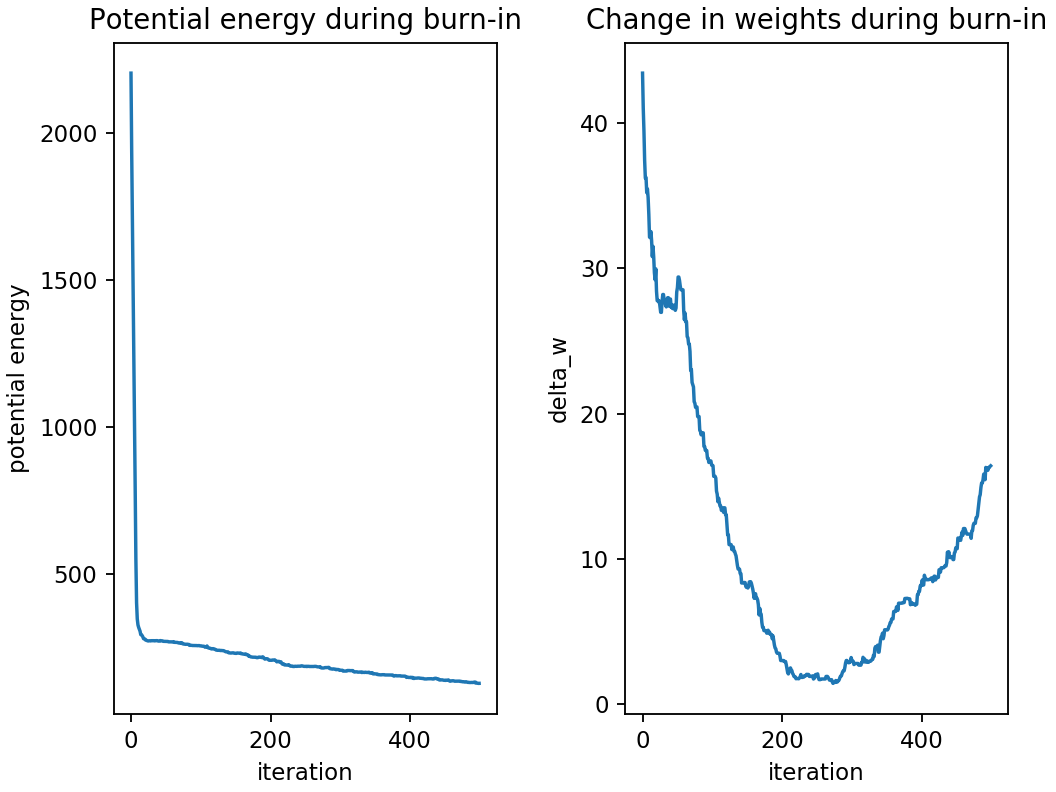

In [9]:
x_train = numpy.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
y_train = numpy.asarray([-2.,  1.2224,    4.,  4.,  1.2224, -2.])
weight_sigma = 1.0
data_sigma = 0.1
architecture = (10,)
activation = relu

_fill_normal = lambda *args: normal_samples(*args, scale=weights_sigma)
layer_params = make_nn_params_as_list_of_dicts(
        architecture, n_dims_input=1, n_dims_output=1, weight_fill_func=_fill_normal, bias_fill_func=_fill_normal
)
initial_params, layer_shapes = layer_params_to_flat_params(layer_params)
nn_kwargs = {
    "layer_shapes": layer_shapes,
    "x": x_train,
    "y": y_train,
    "activation_func": activation,
    "sigma_data": data_sigma,
    "sigma_weights": weight_sigma
}

step_size = 0.001
n_full_burnin_steps = 0.5
n_burnin_iters = int(n_full_burnin_steps / step_size)
num_full_steps = 1
n_burnin_leapfrog_steps = 50
n_hmc_iters = int(n_burnin_iters / step_size)

param_samples, potential_energy_samples, accept_rate = run_HMC_sampler(
        initial_params,
        calc_potential_energy = nn_energy,
        calc_potential_energy_kwargs = nn_kwargs,
        calc_kinetic_energy = default_kinetic_energy,
        calc_kinetic_energy_kwargs = None,
        n_hmc_iters=n_burnin_iters,
        n_leapfrog_steps=n_burnin_leapfrog_steps,
        step_size=step_size,
        random_state=None,
)

fig = pyplot.figure(num=next_fig(), constrained_layout=True)
gridspec = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gridspec[0, 0])
ax.plot(potential_energy_samples)
ax.set_ylabel("potential energy")
ax.set_xlabel("iteration")
ax.set_title("Potential energy during burn-in")

w_median = numpy.median(param_samples, axis=0)
delta_w = numpy.sum((numpy.array(param_samples) - w_median) ** 2, axis=1)
ax = fig.add_subplot(gridspec[0, 1])
ax.plot(delta_w)
ax.set_ylabel("delta_w")
ax.set_xlabel("iteration")
ax.set_title("Change in weights during burn-in");


Burned in after 2.5 full steps
Burned in after 1.0 full steps
Burned in after 2.0 full steps


<IPython.core.display.Javascript object>


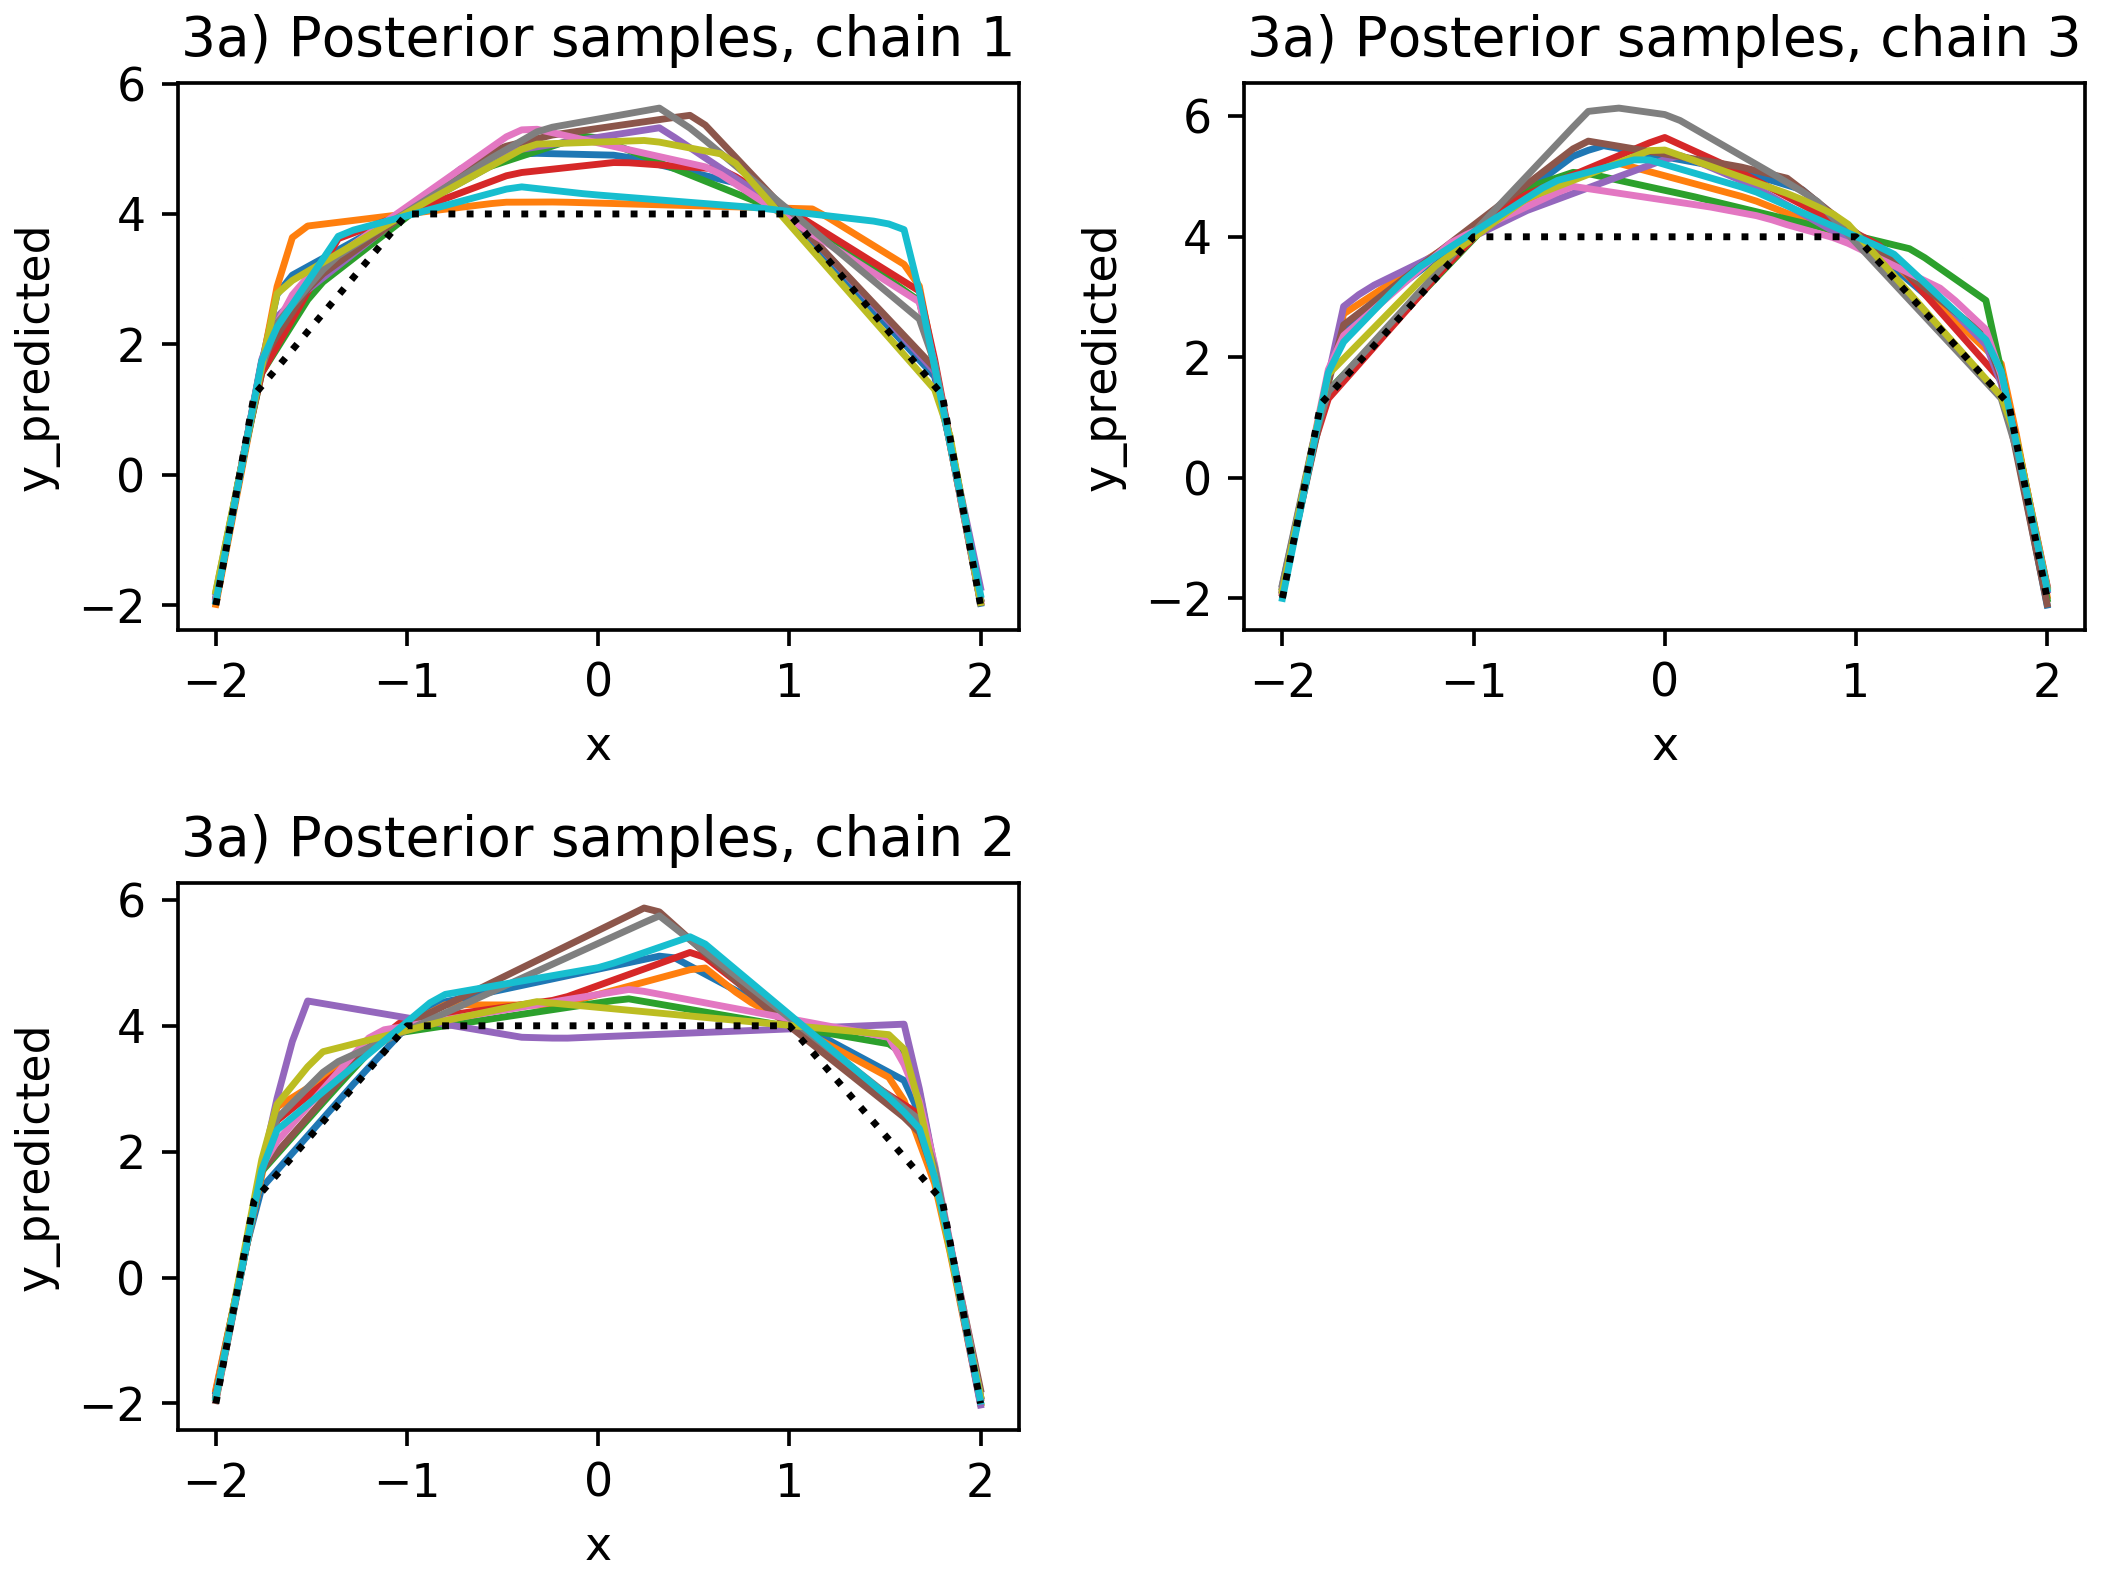

<IPython.core.display.Javascript object>


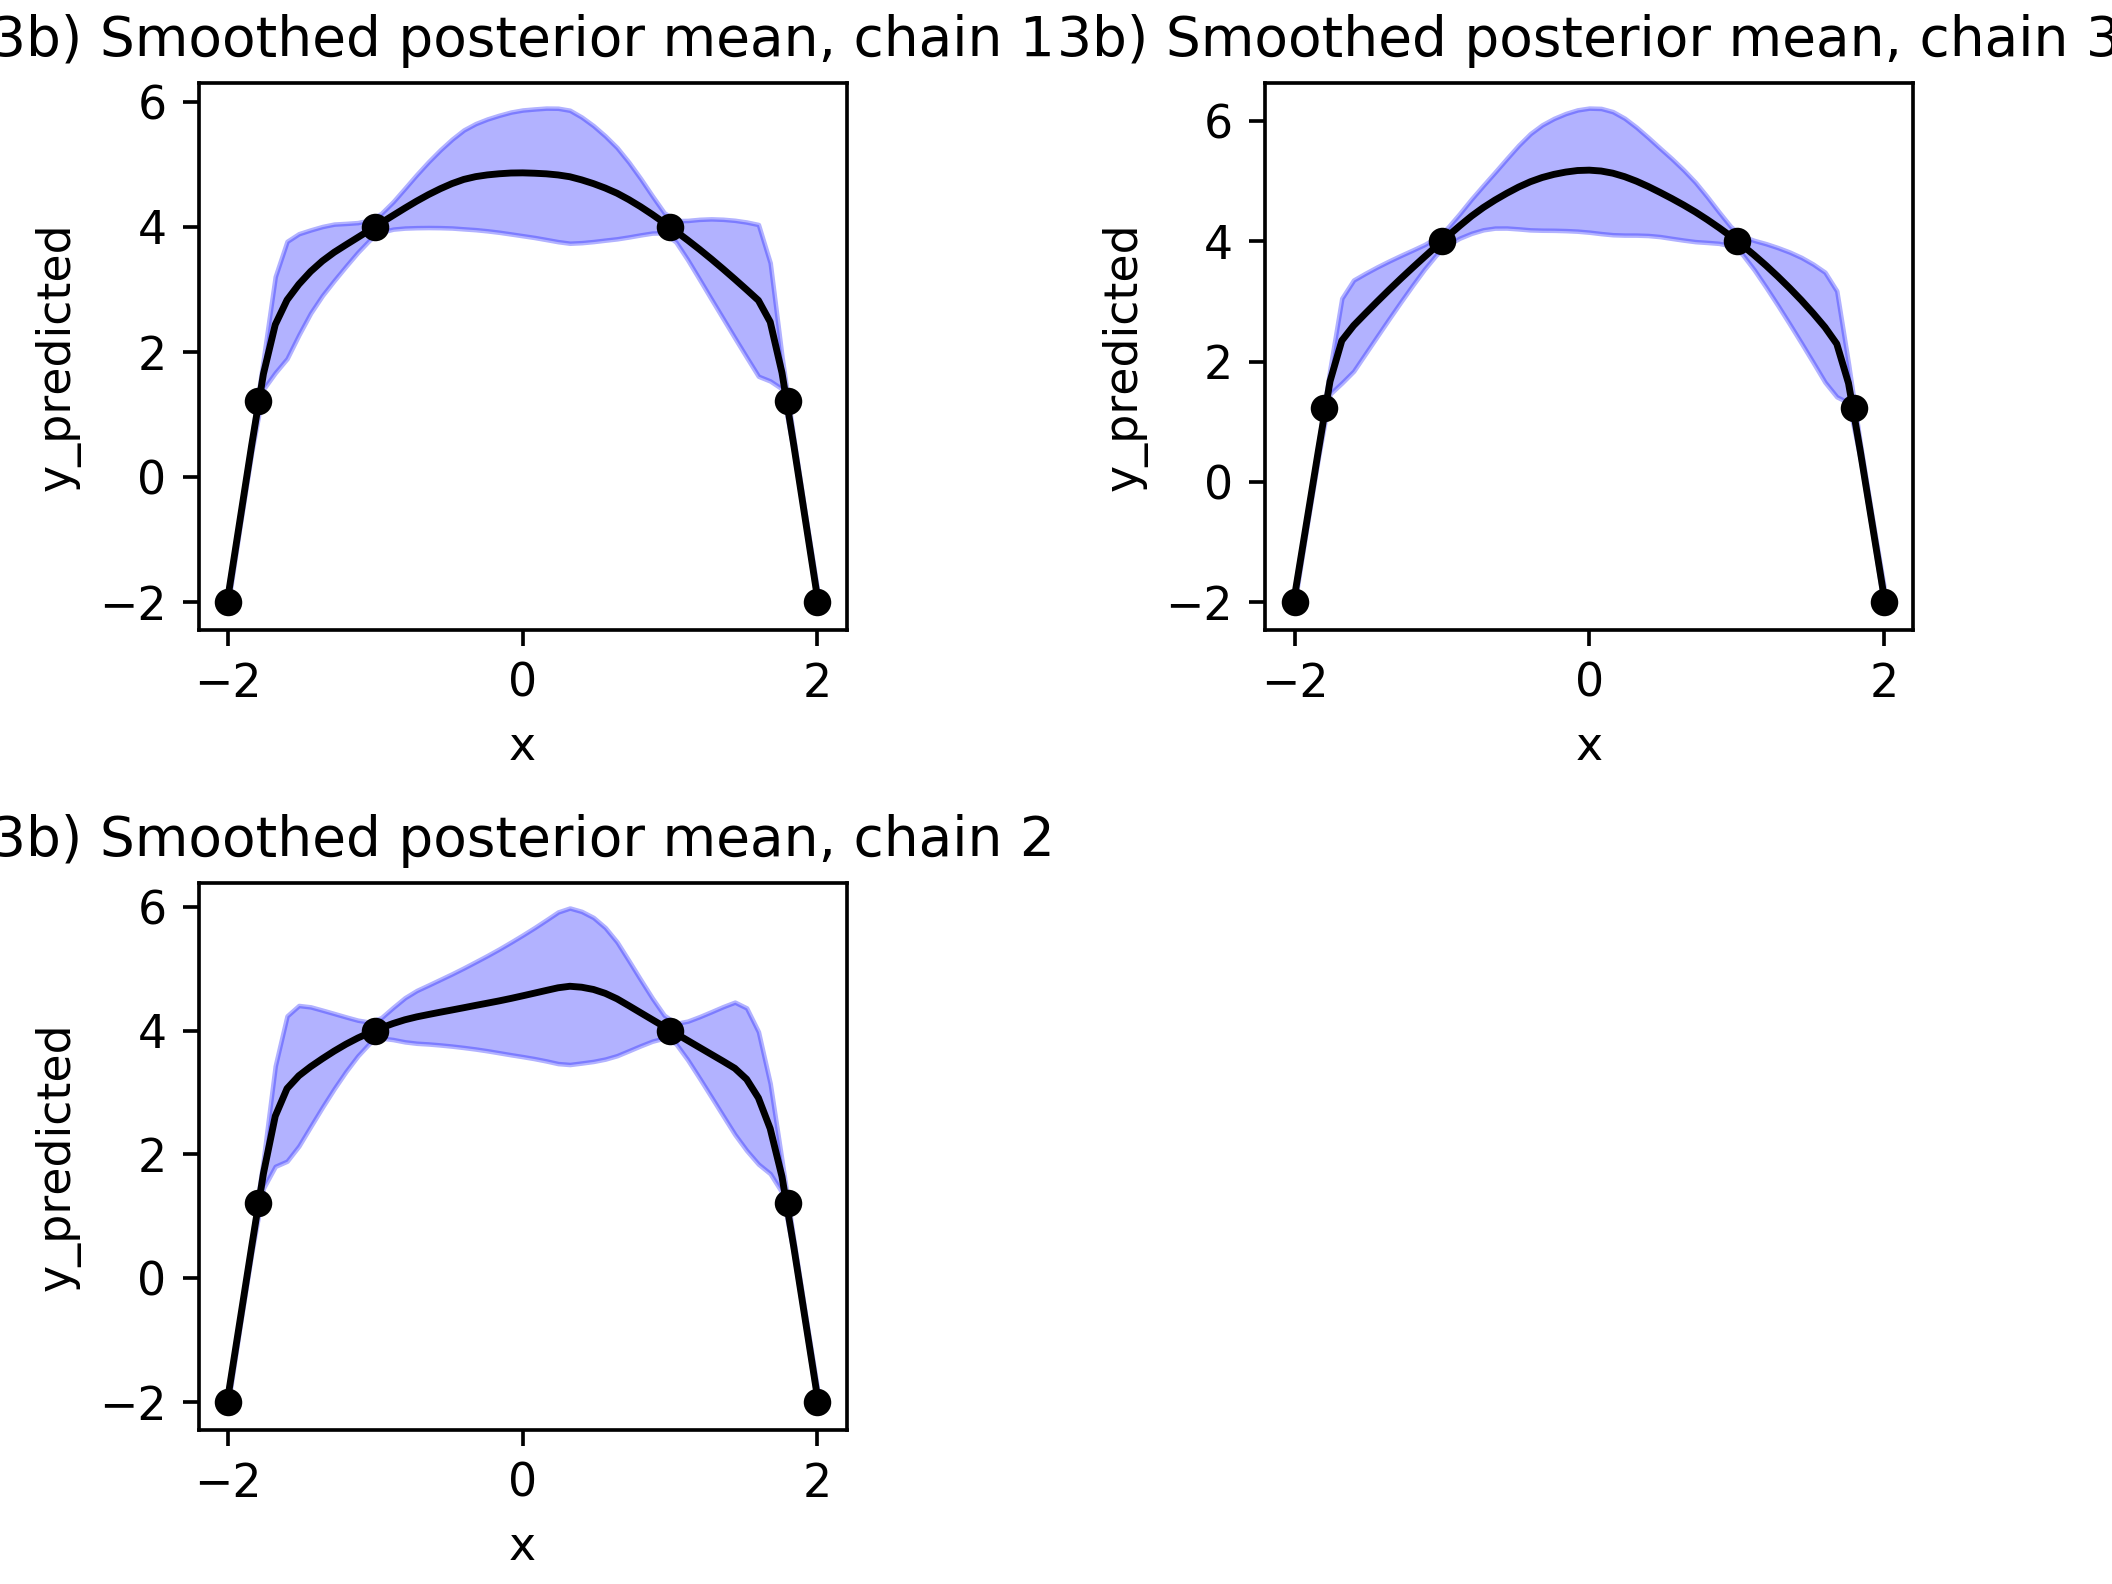

In [229]:
x_train = numpy.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
y_train = numpy.asarray([-2.,  1.2224,    4.,  4.,  1.2224, -2.])
weights_sigma = 1.0
data_sigma = 0.1
architecture = (10,)
activation = relu
n_hmc_iters = 1000
num_chains = 3
step_size = 0.001

_fill_normal = lambda *args: normal_samples(*args, scale=weights_sigma)
layer_params = make_nn_params_as_list_of_dicts(
        architecture, n_dims_input=1, n_dims_output=1, weight_fill_func=_fill_normal, bias_fill_func=_fill_normal
)
initial_params, layer_shapes = layer_params_to_flat_params(layer_params)
nn_kwargs = {
    "layer_shapes": layer_shapes,
    "x": x_train,
    "y": y_train,
    "activation_func": activation,
    "sigma_data": data_sigma,
    "sigma_weights": weights_sigma
}
def _param_initializer():
    _layer_params = make_nn_params_as_list_of_dicts(
        architecture, n_dims_input=1, n_dims_output=1, weight_fill_func=normal_samples, bias_fill_func=normal_samples
    )
    _initial_params, __ = layer_params_to_flat_params(_layer_params)
    return _initial_params

param_samples, potential_energy_samples, accept_rate = run_HMC_chain(
        _param_initializer,
        calc_potential_energy = nn_energy,
        calc_potential_energy_kwargs = nn_kwargs,
        calc_kinetic_energy = default_kinetic_energy,
        num_chains=3,
        n_check_burnin_iters=0.5,
        step_size=step_size,
        n_burnin_leapfrog_steps=50,
        n_sample_leapfrog_steps=50
)

n_random_params = 10
n_x_plot = 51
fig = pyplot.figure(num=next_fig(), constrained_layout=True)
num_rows = int(numpy.ceil(num_chains / 2))
gridspec = fig.add_gridspec(num_rows, 2)

x_plot = numpy.linspace(-2.0, 2.0, n_x_plot)
for c in range(num_chains):
    inds = numpy.random.choice(n_hmc_iters, n_random_params, replace=False)
    flat_params = param_samples[c].squeeze().take(inds, axis=0)
    y_predict = numpy.array(
        [
            flat_params_to_y_predict(flat_params[_s].squeeze(), layer_shapes, x_plot, activation_func=None)
            for _s in range(n_random_params)
        ]
    )
    
    ax = fig.add_subplot(gridspec[c % 2, c // 2])
    ax.plot(x_plot, y_predict.transpose())
    ax.plot(x_train, y_train, "k:")
    ax.set_ylabel("y_predicted")
    ax.set_xlabel("x")
    ax.set_title("3a) Posterior samples, chain %d" % (c + 1))
    
fig = pyplot.figure(num=next_fig(), constrained_layout=True)
num_rows = int(numpy.ceil(num_chains / 2))
gridspec = fig.add_gridspec(num_rows, 2)

for c in range(num_chains):
    y_predict = numpy.array(
        [
            flat_params_to_y_predict(param_samples[c, _s, :].squeeze(), layer_shapes, x_plot, activation_func=None)
            for _s in range(param_samples.shape[1])
        ]
    )
    y_mean = numpy.mean(y_predict, axis=0)
    y_std = numpy.std(y_predict, axis=0)
    
    ax = fig.add_subplot(gridspec[c % 2, c // 2])
    ax.plot(x_plot, y_mean, "k-")
    ax.fill_between(x_plot, y_mean - 2 * y_std, y_mean + 2 * y_std, color='b', alpha=0.3)
    ax.plot(x_train, y_train, "ko", markersize=5, markerfacecolor='k')
    ax.set_ylabel("y_predicted")
    ax.set_xlabel("x")
    ax.set_title("3b) Smoothed posterior mean, chain %d" % (c + 1));